In [ ]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import f1_score as f1
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Conv2D, MaxPooling1D, Dropout, SimpleRNN, BatchNormalization, Flatten
from sklearn import model_selection
import tensorflow as tf
from sklearn.neural_network import MLPClassifier
#from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import MinMaxScaler
import itertools
import sklearn
import keras.backend as K
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
#import joblib
#!pip install scikit-learn==0.24

In [ ]:
df_data = pd.read_csv(r'/content/dataset_phishing.csv')
#y=[1 if mail=='legitimate' else 0 for mail in data.status]
df_data.shape
df_data.head(5)
df_data['target'] = pd.get_dummies(df_data['status'])['legitimate'].astype('int')
df_data.drop('status',axis = 1, inplace=True)
df_data[['url','target']].head(5)

tmp = df_data.isnull().sum().reset_index(name='missing_val')
tmp[tmp['missing_val']!= 0]

,index,missing_val


In [ ]:
likely_cat = {}
for var in df_data.iloc[:,1:].columns:
    likely_cat[var] = 1.*df_data[var].nunique()/df_data[var].count() < 0.002 

num_cols = []
cat_cols = []
for col in likely_cat.keys():
    if (likely_cat[col] == False):
        num_cols.append(col)
    else:
        cat_cols.append(col)

AttributeError: ignored

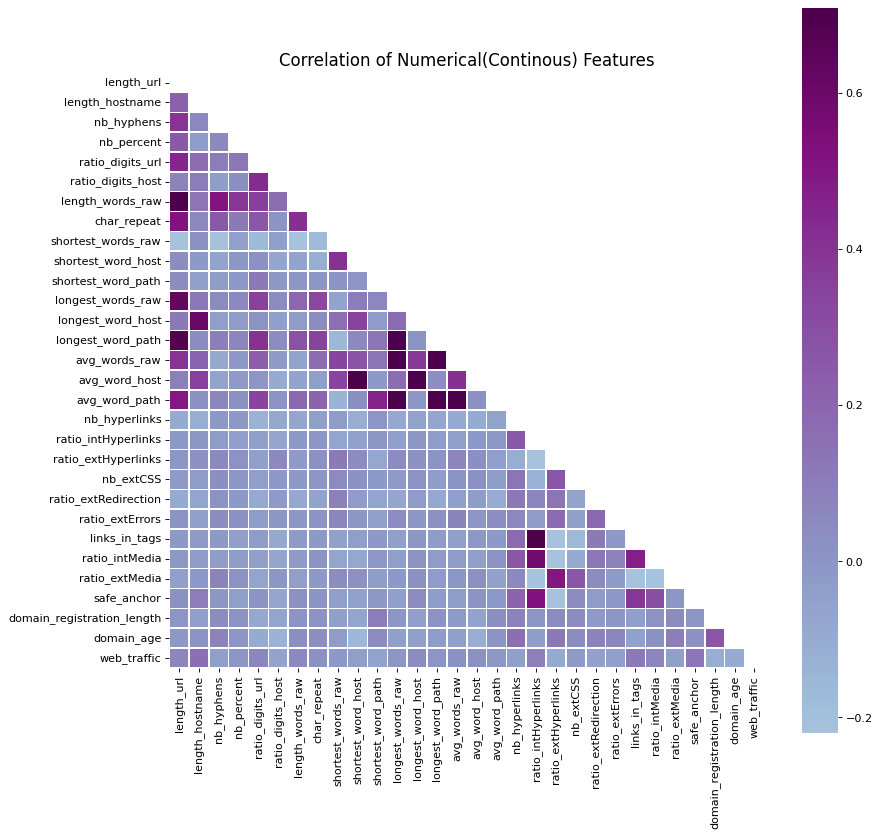

In [ ]:
#Taking all columns except URL 
corr = df_data[num_cols].corr()

fig = plt.figure(figsize=(12,12),dpi=80)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='BuPu', robust=True, center=0,
            square=True, linewidths=.5)
plt.title('Correlation of Numerical(Continous) Features', fontsize=15,font="Serif")
plt.show()

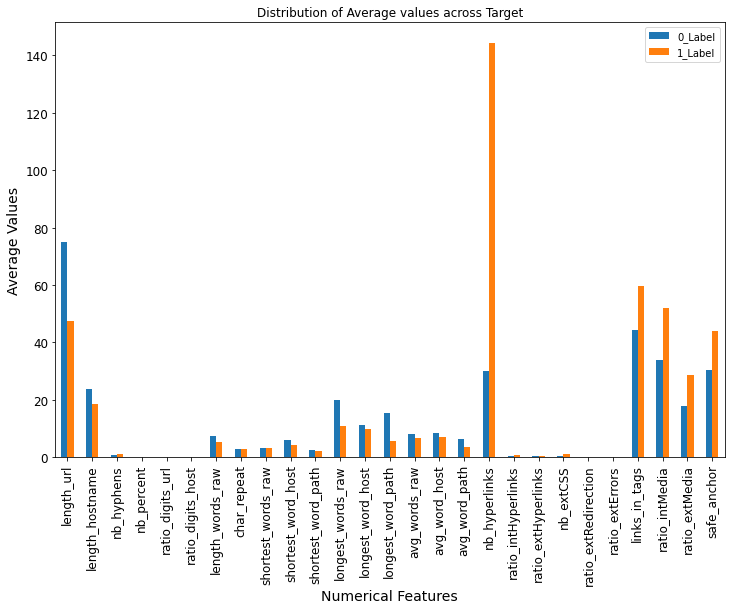

In [ ]:
df_distr =df_data.groupby('target')[num_cols].mean().reset_index().T
df_distr.rename(columns={0:'0_Label',1:"1_Label"}, inplace=True)

#plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'
ax = df_distr[1:-3][['0_Label','1_Label']].plot(kind='bar', title ="Distribution of Average values across Target", figsize=(12, 8), legend=True, fontsize=12)
ax.set_xlabel("Numerical Features", fontsize=14)
ax.set_ylabel("Average Values", fontsize=14)
#ax.set_ylim(0,500000)
plt.show()

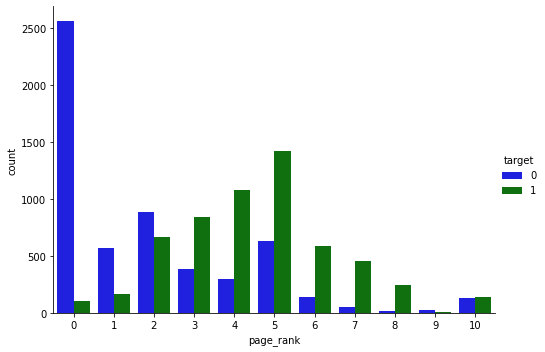

In [ ]:
sns.catplot("page_rank", hue="target", data=df_data, kind="count", 
            palette={1:"green", 0:"blue"} ,height=5.0, aspect=11.7/8.27 )

In [ ]:
A = df_data.copy()

b = A.pop('target')
#X = data.drop(columns=['url','target','nb_underscore','nb_or','sfh','punycode'])
A = df_data.drop(columns=['url','target'])

#scaler = MinMaxScaler()
#A = scaler.fit_transform(A)

A_train, A_valid, b_train, b_valid = \
    train_test_split(A, b, stratify=b, train_size=0.7)


inputt_shape = [A_train.shape[1]]
print("Input shape is ", inputt_shape)
#A.head()


Input shape is  [87]


In [ ]:
#Train & Test Set
X= df_data.iloc[: , 1:-1]
#y = upsampled_df['Churn']
y= df_data['target']

#scaler = MinMaxScaler()
#X = scaler.fit_transform(X)

knn = KNeighborsClassifier(n_neighbors=3)
sfs = SequentialFeatureSelector(knn, n_features_to_select=3)
sfs.fit(X, y)
sfs.transform(X)

#train_x,test_x,train_y,test_y = train_test_split(X,y,random_state=42)
#print("\n--Training data samples--")
#print(train_x.shape)

array([[17.,  1.,  4.],
       [30.,  1.,  2.],
       [ 4.,  1.,  0.],
       ...,
       [68.,  1., 10.],
       [32.,  0.,  4.],
       [21.,  1.,  0.]])

In [ ]:
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.7)
X_train = np.expand_dims(X_train, axis=2)
X_valid = np.expand_dims(X_valid, axis=2)


input_shape = [X_train[1].shape]
print("Input shape is ", input_shape)

print(X_train.shape)
print(X_train)

Input shape is  [(87, 1)]
(8000, 87, 1)
[[[93.]
  [21.]
  [ 0.]
  ...
  [ 0.]
  [ 1.]
  [ 0.]]

 [[36.]
  [21.]
  [ 0.]
  ...
  [ 0.]
  [ 0.]
  [ 2.]]

 [[35.]
  [26.]
  [ 0.]
  ...
  [ 0.]
  [ 0.]
  [ 3.]]

 ...

 [[33.]
  [16.]
  [ 0.]
  ...
  [ 0.]
  [ 0.]
  [ 7.]]

 [[45.]
  [38.]
  [ 0.]
  ...
  [ 0.]
  [ 1.]
  [ 5.]]

 [[75.]
  [15.]
  [ 0.]
  ...
  [ 0.]
  [ 1.]
  [ 5.]]]


In [ ]:
#i am joining the lstm and cnn models
def create_model( dropout_rate):
    model = keras.Sequential()
    model.add(BatchNormalization(input_shape=(87,1)))
    model.add(Conv1D(filters=64,kernel_size=7,activation='relu'))
    model.add(BatchNormalization())
    #layers.Conv1D(filters=32,kernel_size=3,activation='relu'),
    #layers.BatchNormalization(),
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(LSTM(100))
    model.add(Dropout(0.3))
    model.add(Flatten()) # flatten out the layers
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

      # Declare parameter values
dropout_rate = 0.1
epochs = 1
batch_size = 20
learn_rate = 0.001

# Create the model object by calling the create_model function we created above
model = create_model(dropout_rate)

# Fit the model onto the training data
model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=1)

In [ ]:
# Create the model
model = KerasClassifier(build_fn=create_model, verbose=1)

# Define the parameters that you wish to use in your Grid Search along
# with the list of values that you wish to try out
learn_rate = [0.001, 0.02, 0.2, 0.3, 0.4, 0.5]
dropout_rate = [0.0, 0.2, 0.4, 0.6, 0.8]
batch_size = [10, 20, 30, 40, 50]
epochs = [1, 5, 10, 20, 50]

seed = 42

# Make a dictionary of the grid search parameters
param_grid = dict(dropout_rate=dropout_rate, batch_size=batch_size, epochs=epochs )

# Build and fit the GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid,
                    cv=KFold(random_state=None),verbose=10)

grid_results = grid.fit(x, y)

# Summarize the results in a readable format
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))

means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))

In [ ]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 3*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

In [ ]:
#model.compile(
 #   optimizer='adam',
  #  loss='binary_crossentropy',
   # metrics=METRICS,
#)

#early_stopping = keras.callbacks.EarlyStopping(
#    patience=50,
#    min_delta=0.0001,
#    restore_best_weights=True,
#)
#history = model.fit(
 #   X_train, y_train,
  #  validation_data=(X_valid, y_valid),
   # batch_size=512,
    #epochs=50,
    #callbacks=[early_stopping],
#)

Epoch 1/50
16/16 [==============================] - 13s 564ms/step - loss: 0.7926 - accuracy: 1.0000 - precision: 0.5812 - recall: 0.6950 - auc: 0.6184 - f1_score: 0.9100 - val_loss: 0.6975 - val_accuracy: 1.0000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.5064 - val_f1_score: 1.0006
Epoch 2/50
16/16 [==============================] - 8s 492ms/step - loss: 0.6928 - accuracy: 1.0000 - precision: 0.6995 - recall: 0.6965 - auc: 0.7288 - f1_score: 1.0468 - val_loss: 0.6992 - val_accuracy: 1.0000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.4391 - val_f1_score: 1.0006
Epoch 3/50
16/16 [==============================] - 7s 453ms/step - loss: 0.6750 - accuracy: 1.0000 - precision: 0.6853 - recall: 0.6967 - auc: 0.7302 - f1_score: 1.0372 - val_loss: 0.7003 - val_accuracy: 1.0000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.6068 - val_f1_score: 1.0006
Epoch 4/50
16/16 [==============================] - 8s 502ms/step - loss: 0.6670 - accuracy: 1.0000 - pre

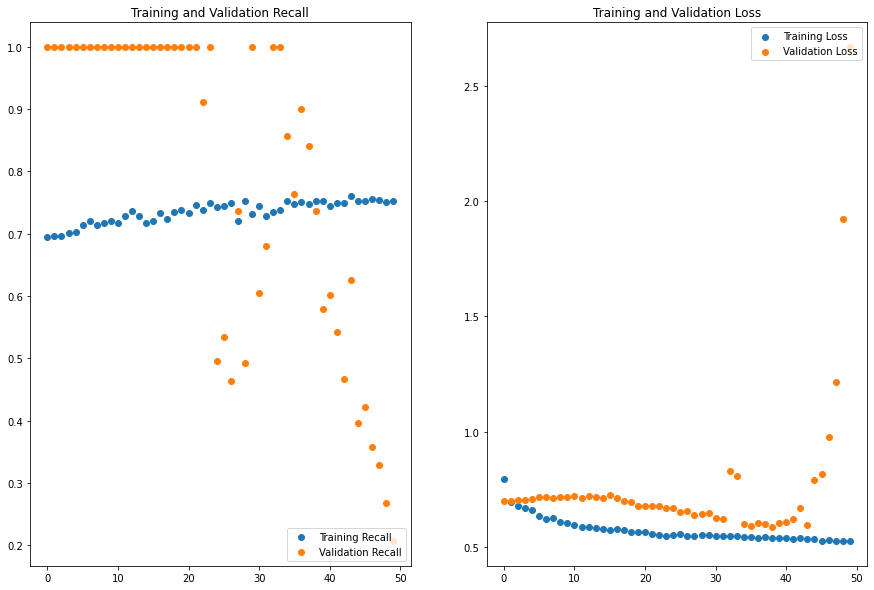

In [ ]:
acc = history.history['recall']
val_acc = history.history['val_recall']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss']))
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.scatter(epochs_range, acc, label='Training Recall')
plt.scatter(epochs_range, val_acc, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')
plt.subplot(1, 2, 2)
plt.scatter(epochs_range, loss, label='Training Loss')
plt.scatter(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

              precision    recall  f1-score   support

         0.0       0.91      0.54      0.68      2930
         1.0       0.21      0.71      0.32       500

    accuracy                           0.56      3430
   macro avg       0.56      0.62      0.50      3430
weighted avg       0.81      0.56      0.62      3430



0.5606413994169096

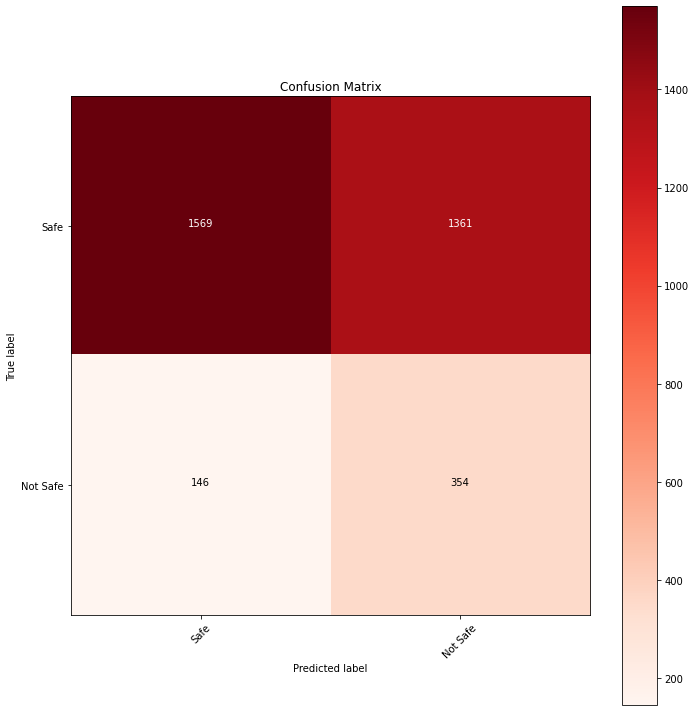

In [ ]:
y_pred1 = model.predict(X_valid).reshape(-1)
#print (y_pred1[:5])
y_pred1 = np.round(y_pred1)
print ( classification_report(y_pred1, y_valid))
cm1 = confusion_matrix(y_pred1, y_valid)


def plot_confusion_matrix1(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Reds):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
target_names = ["Safe", "Not Safe"]
plot_confusion_matrix1(cm1, target_names, normalize=False, title='Confusion Matrix')
accuracy_score(y_valid, y_pred1)


In [ ]:
#Deep learning model
model1 = keras.Sequential([
    layers.BatchNormalization(input_shape=inputt_shape),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])


In [ ]:
model1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS,
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=50,
    min_delta=0.01,
    restore_best_weights=True,
)
history1 = model1.fit(
    A_train, b_train,
    validation_data=(A_valid, b_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping],
)

Epoch 1/50
16/16 [==============================] - 4s 78ms/step - loss: 0.0086 - accuracy: 1.0000 - precision: 0.9833 - recall: 0.9886 - auc: 0.9948 - val_loss: 0.2087 - val_accuracy: 1.0000 - val_precision: 0.9578 - val_recall: 0.9656 - val_auc: 0.9826
Epoch 2/50
16/16 [==============================] - 1s 43ms/step - loss: 0.0084 - accuracy: 1.0000 - precision: 0.9973 - recall: 0.9980 - auc: 1.0000 - val_loss: 0.2161 - val_accuracy: 1.0000 - val_precision: 0.9587 - val_recall: 0.9621 - val_auc: 0.9815
Epoch 3/50
16/16 [==============================] - 1s 43ms/step - loss: 0.0083 - accuracy: 1.0000 - precision: 0.9975 - recall: 0.9980 - auc: 0.9998 - val_loss: 0.2267 - val_accuracy: 1.0000 - val_precision: 0.9561 - val_recall: 0.9650 - val_auc: 0.9823
Epoch 4/50
16/16 [==============================] - 1s 45ms/step - loss: 0.0064 - accuracy: 1.0000 - precision: 0.9987 - recall: 0.9962 - auc: 1.0000 - val_loss: 0.2266 - val_accuracy: 1.0000 - val_precision: 0.9514 - val_recall: 0.970

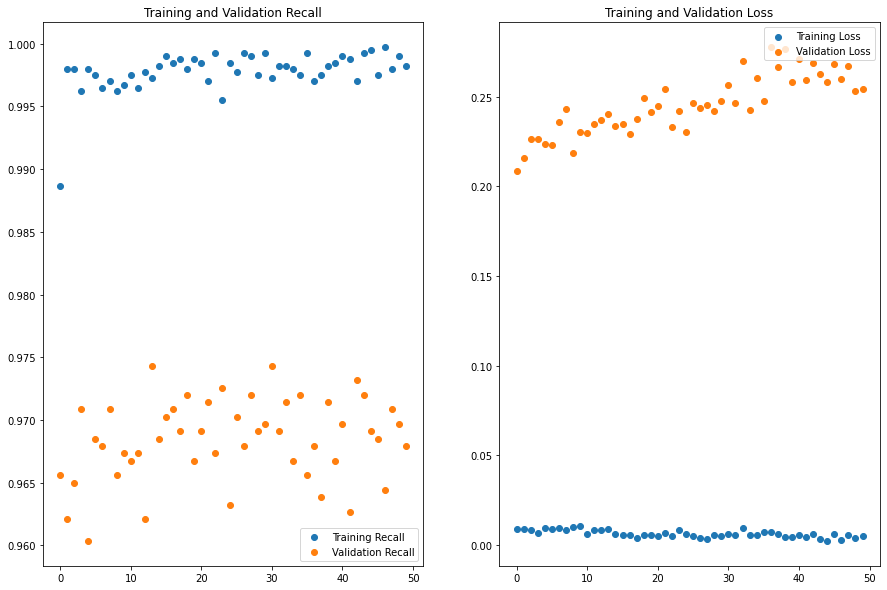

In [ ]:
acc1 = history1.history['recall']
val_acc1 = history1.history['val_recall']
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']
epochs_range1 = range(len(history1.history['val_loss']))
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.scatter(epochs_range1, acc1, label='Training Recall')
plt.scatter(epochs_range1, val_acc1, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')
plt.subplot(1, 2, 2)
plt.scatter(epochs_range1, loss1, label='Training Loss')
plt.scatter(epochs_range1, val_loss1, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96      1702
         1.0       0.97      0.96      0.96      1728

    accuracy                           0.96      3430
   macro avg       0.96      0.96      0.96      3430
weighted avg       0.96      0.96      0.96      3430



0.9641399416909621

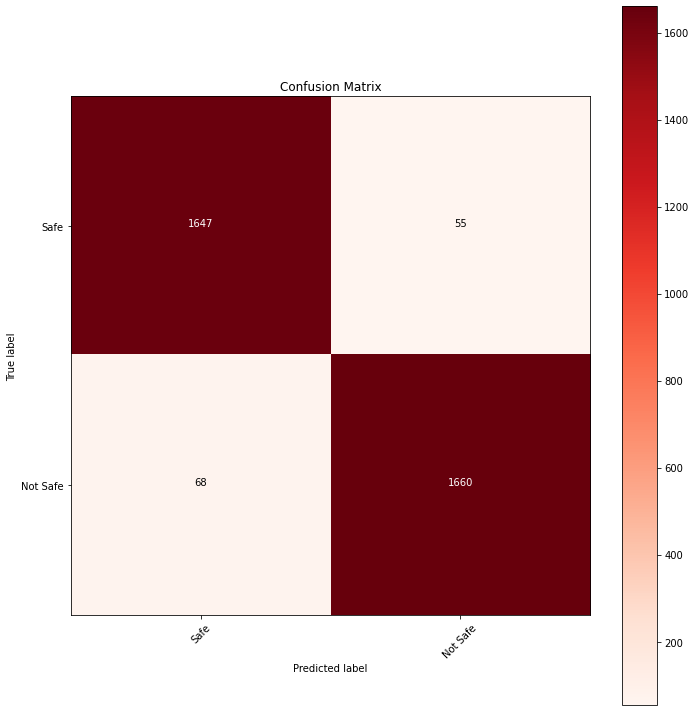

In [ ]:
y_pred2 = model1.predict(A_valid).reshape(-1)
#print (y_pred1[:5])
y_pred2 = np.round(y_pred2)
print ( classification_report(y_pred2, b_valid))
cm2 = confusion_matrix(y_pred2, b_valid)


def plot_confusion_matrix1(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Reds):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
target_names = ["Safe", "Not Safe"]
plot_confusion_matrix1(cm2, target_names, normalize=False, title='Confusion Matrix')
accuracy_score(b_valid, y_pred2)


In [ ]:
# Create model object
clf = MLPClassifier(hidden_layer_sizes=(6,5),random_state=5,verbose=True,learning_rate_init=0.01)
#sfs1 = sfs(clf, k_features=4, forward=True, verbose=2, scoring='neg_mean_squared_error')
# Fit data onto the model
clf.fit(A_train,b_train)

y_pred3=clf.predict(A_valid)
accuracy_score(b_valid,y_pred3)


Iteration 1, loss = 2.93164566
Iteration 2, loss = 0.70114975
Iteration 3, loss = 0.67931473
Iteration 4, loss = 0.67387056
Iteration 5, loss = 0.66884263
Iteration 6, loss = 0.65213746
Iteration 7, loss = 0.60780893
Iteration 8, loss = 0.57189378
Iteration 9, loss = 0.56136755
Iteration 10, loss = 0.59466127
Iteration 11, loss = 0.56592352
Iteration 12, loss = 0.53185632
Iteration 13, loss = 0.50606355
Iteration 14, loss = 0.51558244
Iteration 15, loss = 0.50320857
Iteration 16, loss = 0.47465510
Iteration 17, loss = 0.47286959
Iteration 18, loss = 0.47319648
Iteration 19, loss = 0.50025519
Iteration 20, loss = 0.47900694
Iteration 21, loss = 0.46719696
Iteration 22, loss = 0.48673951
Iteration 23, loss = 0.45383855
Iteration 24, loss = 0.45376525
Iteration 25, loss = 0.46258614
Iteration 26, loss = 0.47770864
Iteration 27, loss = 0.45988662
Iteration 28, loss = 0.48413303
Iteration 29, loss = 0.46561172
Iteration 30, loss = 0.46036258
Iteration 31, loss = 0.46107937
Iteration 32, los

0.8131195335276968

roc_auc_score for Decision tree:  0.5029154518950437


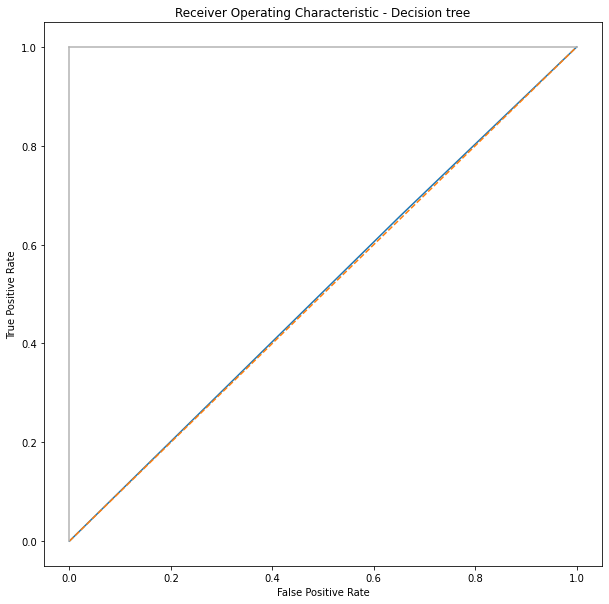

In [ ]:
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_valid, y_pred3)
print('roc_auc_score for Decision tree: ', roc_auc_score(y_valid, y_pred3))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Decision tree')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94      1700
         1.0       0.95      0.94      0.94      1730

    accuracy                           0.94      3430
   macro avg       0.94      0.94      0.94      3430
weighted avg       0.94      0.94      0.94      3430



0.9425655976676385

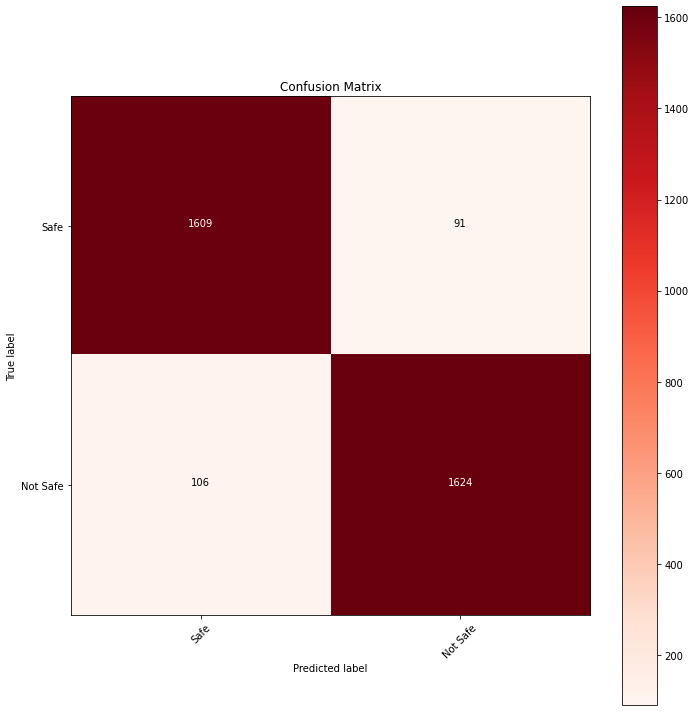

In [ ]:
y_pred3 = model.predict(X_valid).reshape(-1)
#print (y_pred1[:5])
y_pred3 = np.round(y_pred1)
print ( classification_report(y_pred3, y_valid))
cm1 = confusion_matrix(y_pred3, y_valid)


def plot_confusion_matrix1(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Reds):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
target_names = ["Safe", "Not Safe"]
plot_confusion_matrix1(cm1, target_names, normalize=False, title='Confusion Matrix')
accuracy_score(y_valid, y_pred3)


In [24]:
model_rnn = keras.Sequential()
#model_rnn.add(BatchNormalization(input_shape=(87,1)))
model_rnn.add(SimpleRNN(100, input_shape=(87, 1)))
model_rnn.add(Dense(512, activation='relu'))
#model_rnn.add(BatchNormalization())
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(512, activation='relu'))
model_rnn.add(Dense(1, activation='sigmoid'))


In [25]:
model_rnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS,
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=50,
    min_delta=0.01,
    restore_best_weights=True,
)
history2 = model_rnn.fit(
    A_train, b_train,
    validation_data=(A_valid, b_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping],
)

Epoch 1/50
16/16 [==============================] - 7s 251ms/step - loss: 0.4309 - accuracy: 1.0000 - precision: 0.6560 - recall: 0.8598 - auc: 0.6869 - f1_score: 1.1792 - val_loss: 0.2977 - val_accuracy: 1.0000 - val_precision: 0.8778 - val_recall: 0.8589 - val_auc: 0.9445 - val_f1_score: 1.3016
Epoch 2/50
16/16 [==============================] - 3s 178ms/step - loss: 0.2931 - accuracy: 1.0000 - precision: 0.8759 - recall: 0.8950 - auc: 0.9452 - f1_score: 1.3285 - val_loss: 0.2794 - val_accuracy: 1.0000 - val_precision: 0.8723 - val_recall: 0.9160 - val_auc: 0.9487 - val_f1_score: 1.3402
Epoch 3/50
16/16 [==============================] - 3s 178ms/step - loss: 0.2785 - accuracy: 1.0000 - precision: 0.8764 - recall: 0.9162 - auc: 0.9496 - f1_score: 1.3442 - val_loss: 0.2654 - val_accuracy: 1.0000 - val_precision: 0.8741 - val_recall: 0.9394 - val_auc: 0.9543 - val_f1_score: 1.3583
Epoch 4/50
16/16 [==============================] - 3s 184ms/step - loss: 0.2727 - accuracy: 1.0000 - prec

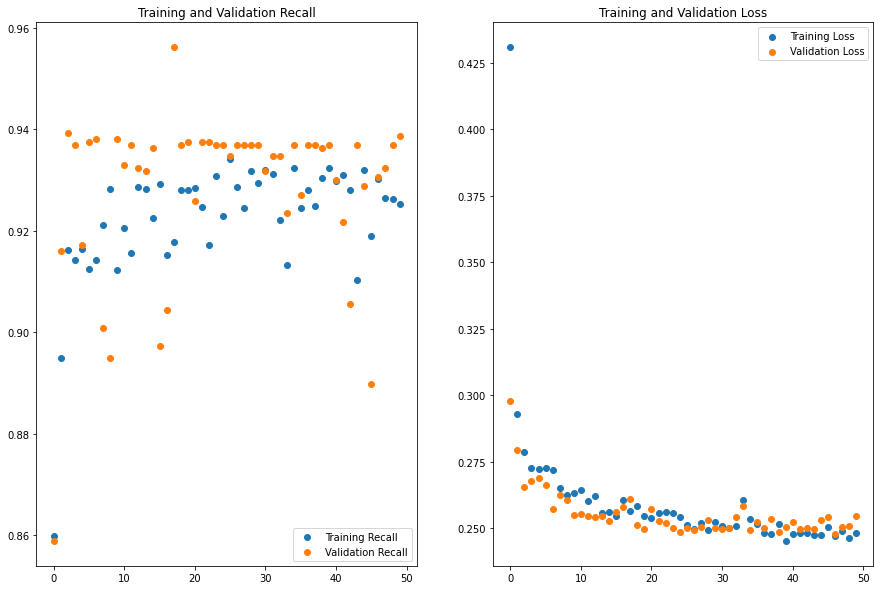

In [26]:
acc1 = history2.history['recall']
val_acc1 = history2.history['val_recall']
loss1 = history2.history['loss']
val_loss1 = history2.history['val_loss']
epochs_range1 = range(len(history2.history['val_loss']))
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.scatter(epochs_range1, acc1, label='Training Recall')
plt.scatter(epochs_range1, val_acc1, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')
plt.subplot(1, 2, 2)
plt.scatter(epochs_range1, loss1, label='Training Loss')
plt.scatter(epochs_range1, val_loss1, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90      1599
         1.0       0.94      0.88      0.91      1831

    accuracy                           0.90      3430
   macro avg       0.90      0.91      0.90      3430
weighted avg       0.91      0.90      0.91      3430



0.9049562682215744

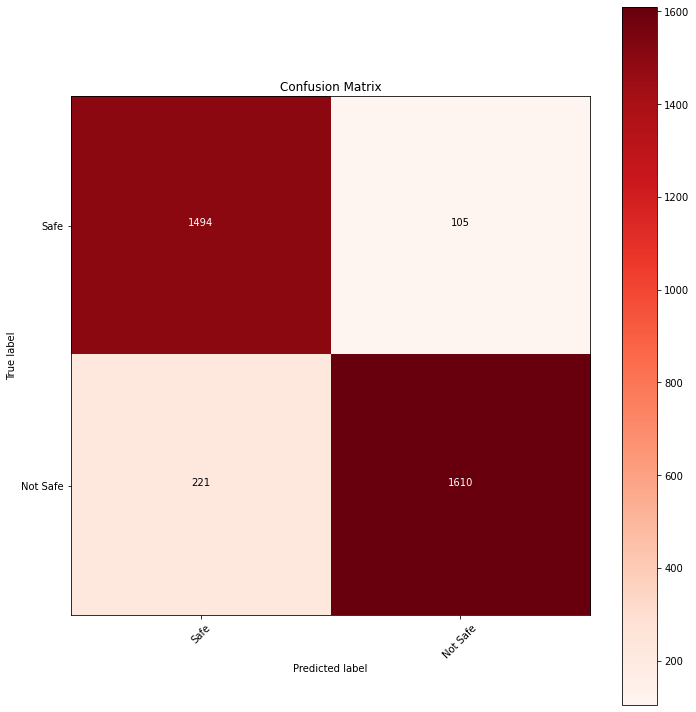

In [27]:
y_pred3 = model_rnn.predict(A_valid).reshape(-1)
#print (y_pred1[:5])
y_pred3 = np.round(y_pred3)
print ( classification_report(y_pred3, b_valid))
cm2 = confusion_matrix(y_pred3, b_valid)


def plot_confusion_matrix1(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Reds):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
target_names = ["Safe", "Not Safe"]
plot_confusion_matrix1(cm2, target_names, normalize=False, title='Confusion Matrix')
accuracy_score(b_valid, y_pred3)
